In [3]:
from Spanve import Spanve
import scanpy as sc

In [81]:
adata = sc.read_h5ad('/Users/koush/Projects/SpaceOracle/data/slideseq/day3_1.h5ad')
adata

AnnData object with n_obs × n_vars = 15920 × 24649
    obs: 'cluster', 'rctd_cluster'
    uns: 'cluster_colors', 'rctd_cluster_colors'
    obsm: 'X_spatial', 'rctd_results', 'spatial'

In [82]:
from Spanve import Spanve, adata_preprocess, adata_preprocess_int  # noqa: E402
import warnings
import numpy as np
warnings.filterwarnings("ignore")
sc.set_figure_params(dpi=150)
np.random.seed(2233)

In [83]:
adata.var_names_make_unique()
sc.pp.filter_cells(adata, min_counts=10)
sc.pp.filter_genes(adata, min_cells=5)
print(adata.shape)

(15920, 15610)


In [84]:
adata.X = adata.X.toarray()
adata.layers["normalized"] = adata_preprocess(adata).X
adata.layers['counts'] = adata.X.copy()
adata.layers['normlized_counts'] =  adata_preprocess_int(adata).X

In [85]:
adata.X.max(), adata.layers['counts'].max()

(521.0, 521.0)

In [86]:
adata.X = adata.layers['counts']
svmodel = Spanve(adata, n_jobs = 16)
svmodel.fit(verbose=True)
print("Detected SV gene number:",svmodel.rejects.sum())
svmodel.result_df.head()

#1 Expected Dist within Nodist Hypoth: 100%|██████████| 15610/15610 [00:01<00:00, 8423.45it/s]


#2 Nearest Neighbors Found


#3 Computing Absolute Substract Value: 100%|██████████| 15610/15610 [00:13<00:00, 1146.17it/s]


#4 Entropy Calculated
#5 G-test Performed
Write results to adata.var['spanve_spatial_features']
#--- Done, using time 18.92 sec ---#
Detected SV gene number: 205


ent     pvals  rejects  fdrs  max_expr
0610009B22Rik  1.294288e-06  0.979606    False   1.0         2
0610009L18Rik  8.758647e-06  0.869847    False   1.0         2
0610010F05Rik  4.292659e-07  0.993189    False   1.0         2
0610012G03Rik  6.534023e-06  0.976281    False   1.0         3
0610030E20Rik  1.964963e-05  0.890537    False   1.0         3

using networkx algorism get communities : 8 
 With size:  [10 32  4 17 51 19 66  6] 



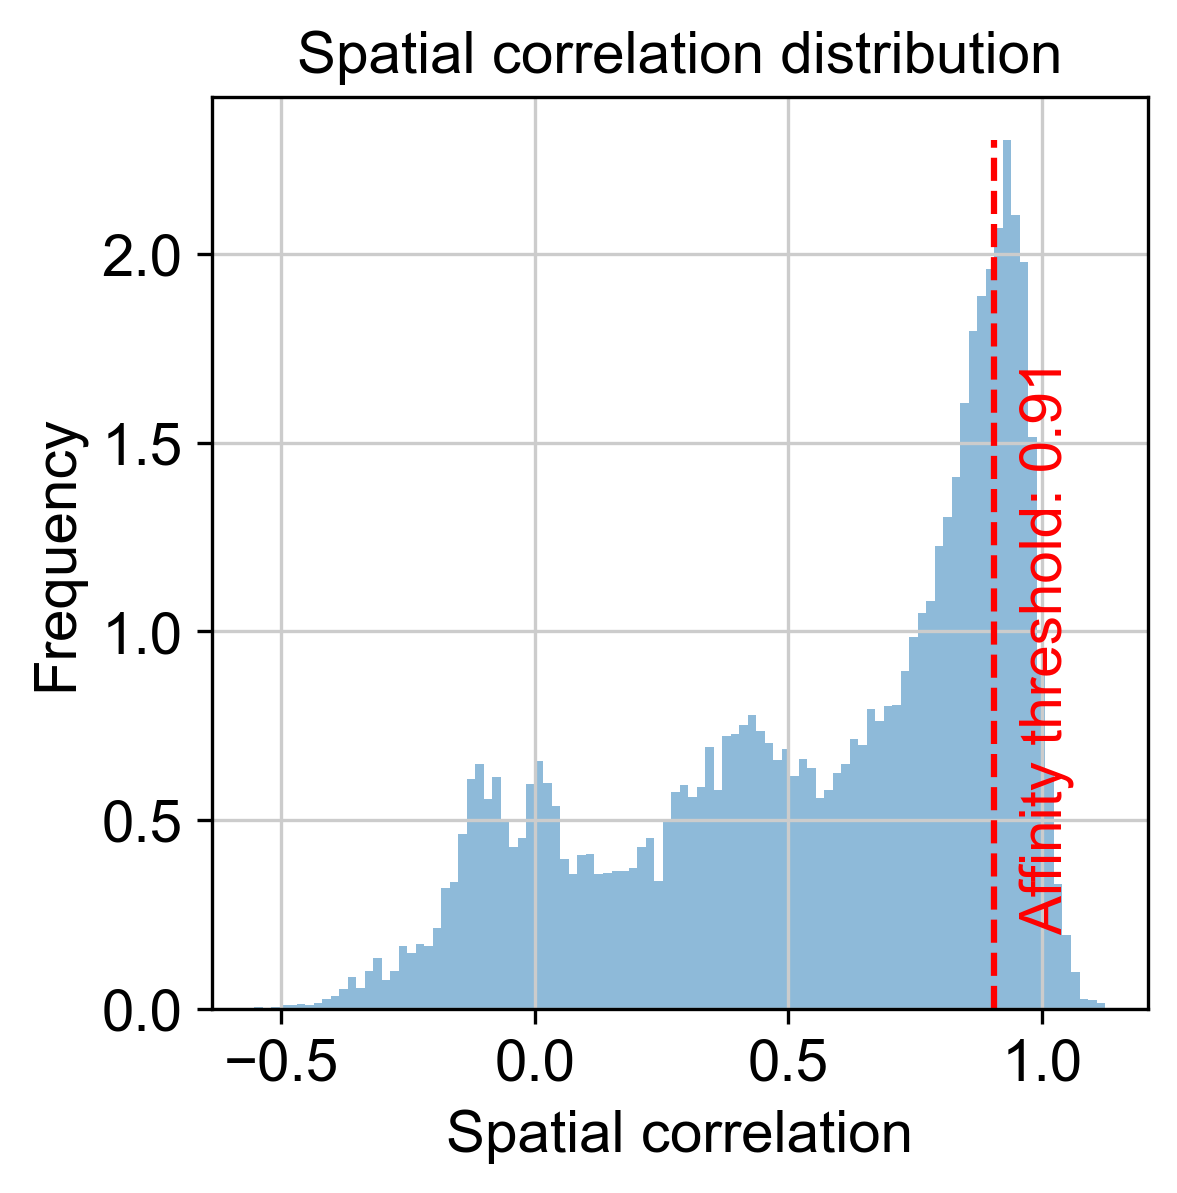

In [87]:
pats = svmodel.detect_spatial_pattern(
    verbose=True,
    clustering_method = 'networkx', # or 'sklearn'
    resolution = 1.25 # kwargs pass for the clustering method
)

In [89]:
svmodel.result_df.sort_values('ent', ascending=False)

ent          pvals  rejects           fdrs  max_expr  \
Igkc      4.880907e-02  7.514860e-292     True  1.173070e-287       521   
mt-Rnr2   4.353027e-02  3.064593e-250     True  2.391915e-246        88   
Actb      3.242499e-02  9.965316e-190     True  5.185286e-186        58   
Cd74      2.837787e-02  1.379060e-178     True  5.381781e-175        35   
Rplp0     2.252932e-02  3.089253e-135     True  9.644648e-132        28   
...                ...            ...      ...            ...       ...   
Gm26202   2.331172e-10   9.999963e-01    False   9.999998e-01         2   
Nol3      2.331172e-10   9.999963e-01    False   9.999998e-01         2   
Pisd-ps1  2.270304e-10   9.978548e-01    False   9.999998e-01         1   
Chn2      5.616580e-11   9.989330e-01    False   9.999998e-01         1   
Bcl2a1c   4.170436e-11   9.990806e-01    False   9.999998e-01         1   

         pattern  
Igkc           0  
mt-Rnr2        0  
Actb           5  
Cd74           2  
Rplp0          4  
...          ...  
Gm26202     None  
Nol3        None  
Pisd-ps1    None  
Chn2        None  
Bcl2a1c     None  

[15610 rows x 6 columns]

In [88]:
svmodel.result_df.query('rejects == True').sort_values('ent', ascending=False)

ent          pvals  rejects           fdrs  max_expr pattern
Igkc       0.048809  7.514860e-292     True  1.173070e-287       521       0
mt-Rnr2    0.043530  3.064593e-250     True  2.391915e-246        88       0
Actb       0.032425  9.965316e-190     True  5.185286e-186        58       5
Cd74       0.028378  1.379060e-178     True  5.381781e-175        35       2
Rplp0      0.022529  3.089253e-135     True  9.644648e-132        28       4
...             ...            ...      ...            ...       ...     ...
Eif1       0.000834   4.020633e-04     True   3.138104e-02         7       4
Tnfrsf13c  0.000830   1.857262e-04     True   1.509993e-02         7       2
Anp32e     0.000828   4.363580e-04     True   3.372054e-02         7       5
Lsp1       0.000827   1.940438e-04     True   1.569442e-02         8       5
Myh9       0.000676   6.421732e-04     True   4.913884e-02         6       5

[205 rows x 6 columns]

In [59]:
import seaborn as sns

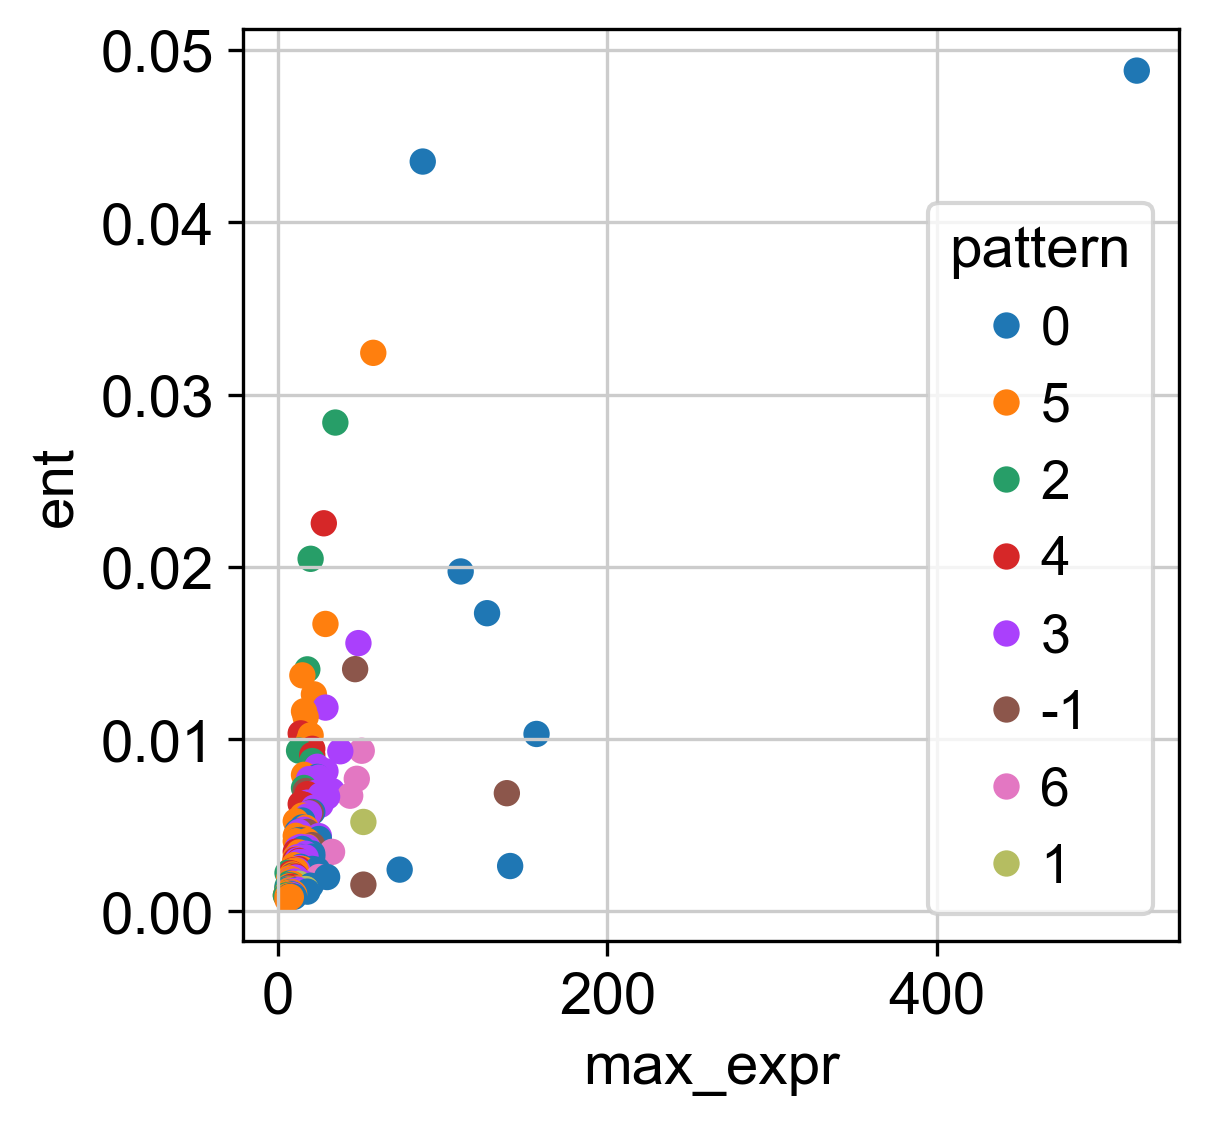

In [90]:
sns.scatterplot(
    data = svmodel.result_df.query('rejects == True').sort_values('ent', ascending=False),
    x = 'max_expr', y='ent', hue='pattern', s=40, alpha=1, edgecolor='none'),

plt.show()


In [33]:
adata.X = adata.layers['normalized'].copy()
i = '0'
vis_list = []
vis_genes = svmodel.result_df.query('pattern == @i').sort_values('ent', ascending=False).index[0:2].tolist()
pat_genes = svmodel.result_df.query('pattern == @i').index
sc.tl.score_genes(adata, gene_list=pat_genes, score_name = f'spatial_pat_{i}')
vis_list += [f'spatial_pat_{i}'] + vis_genes

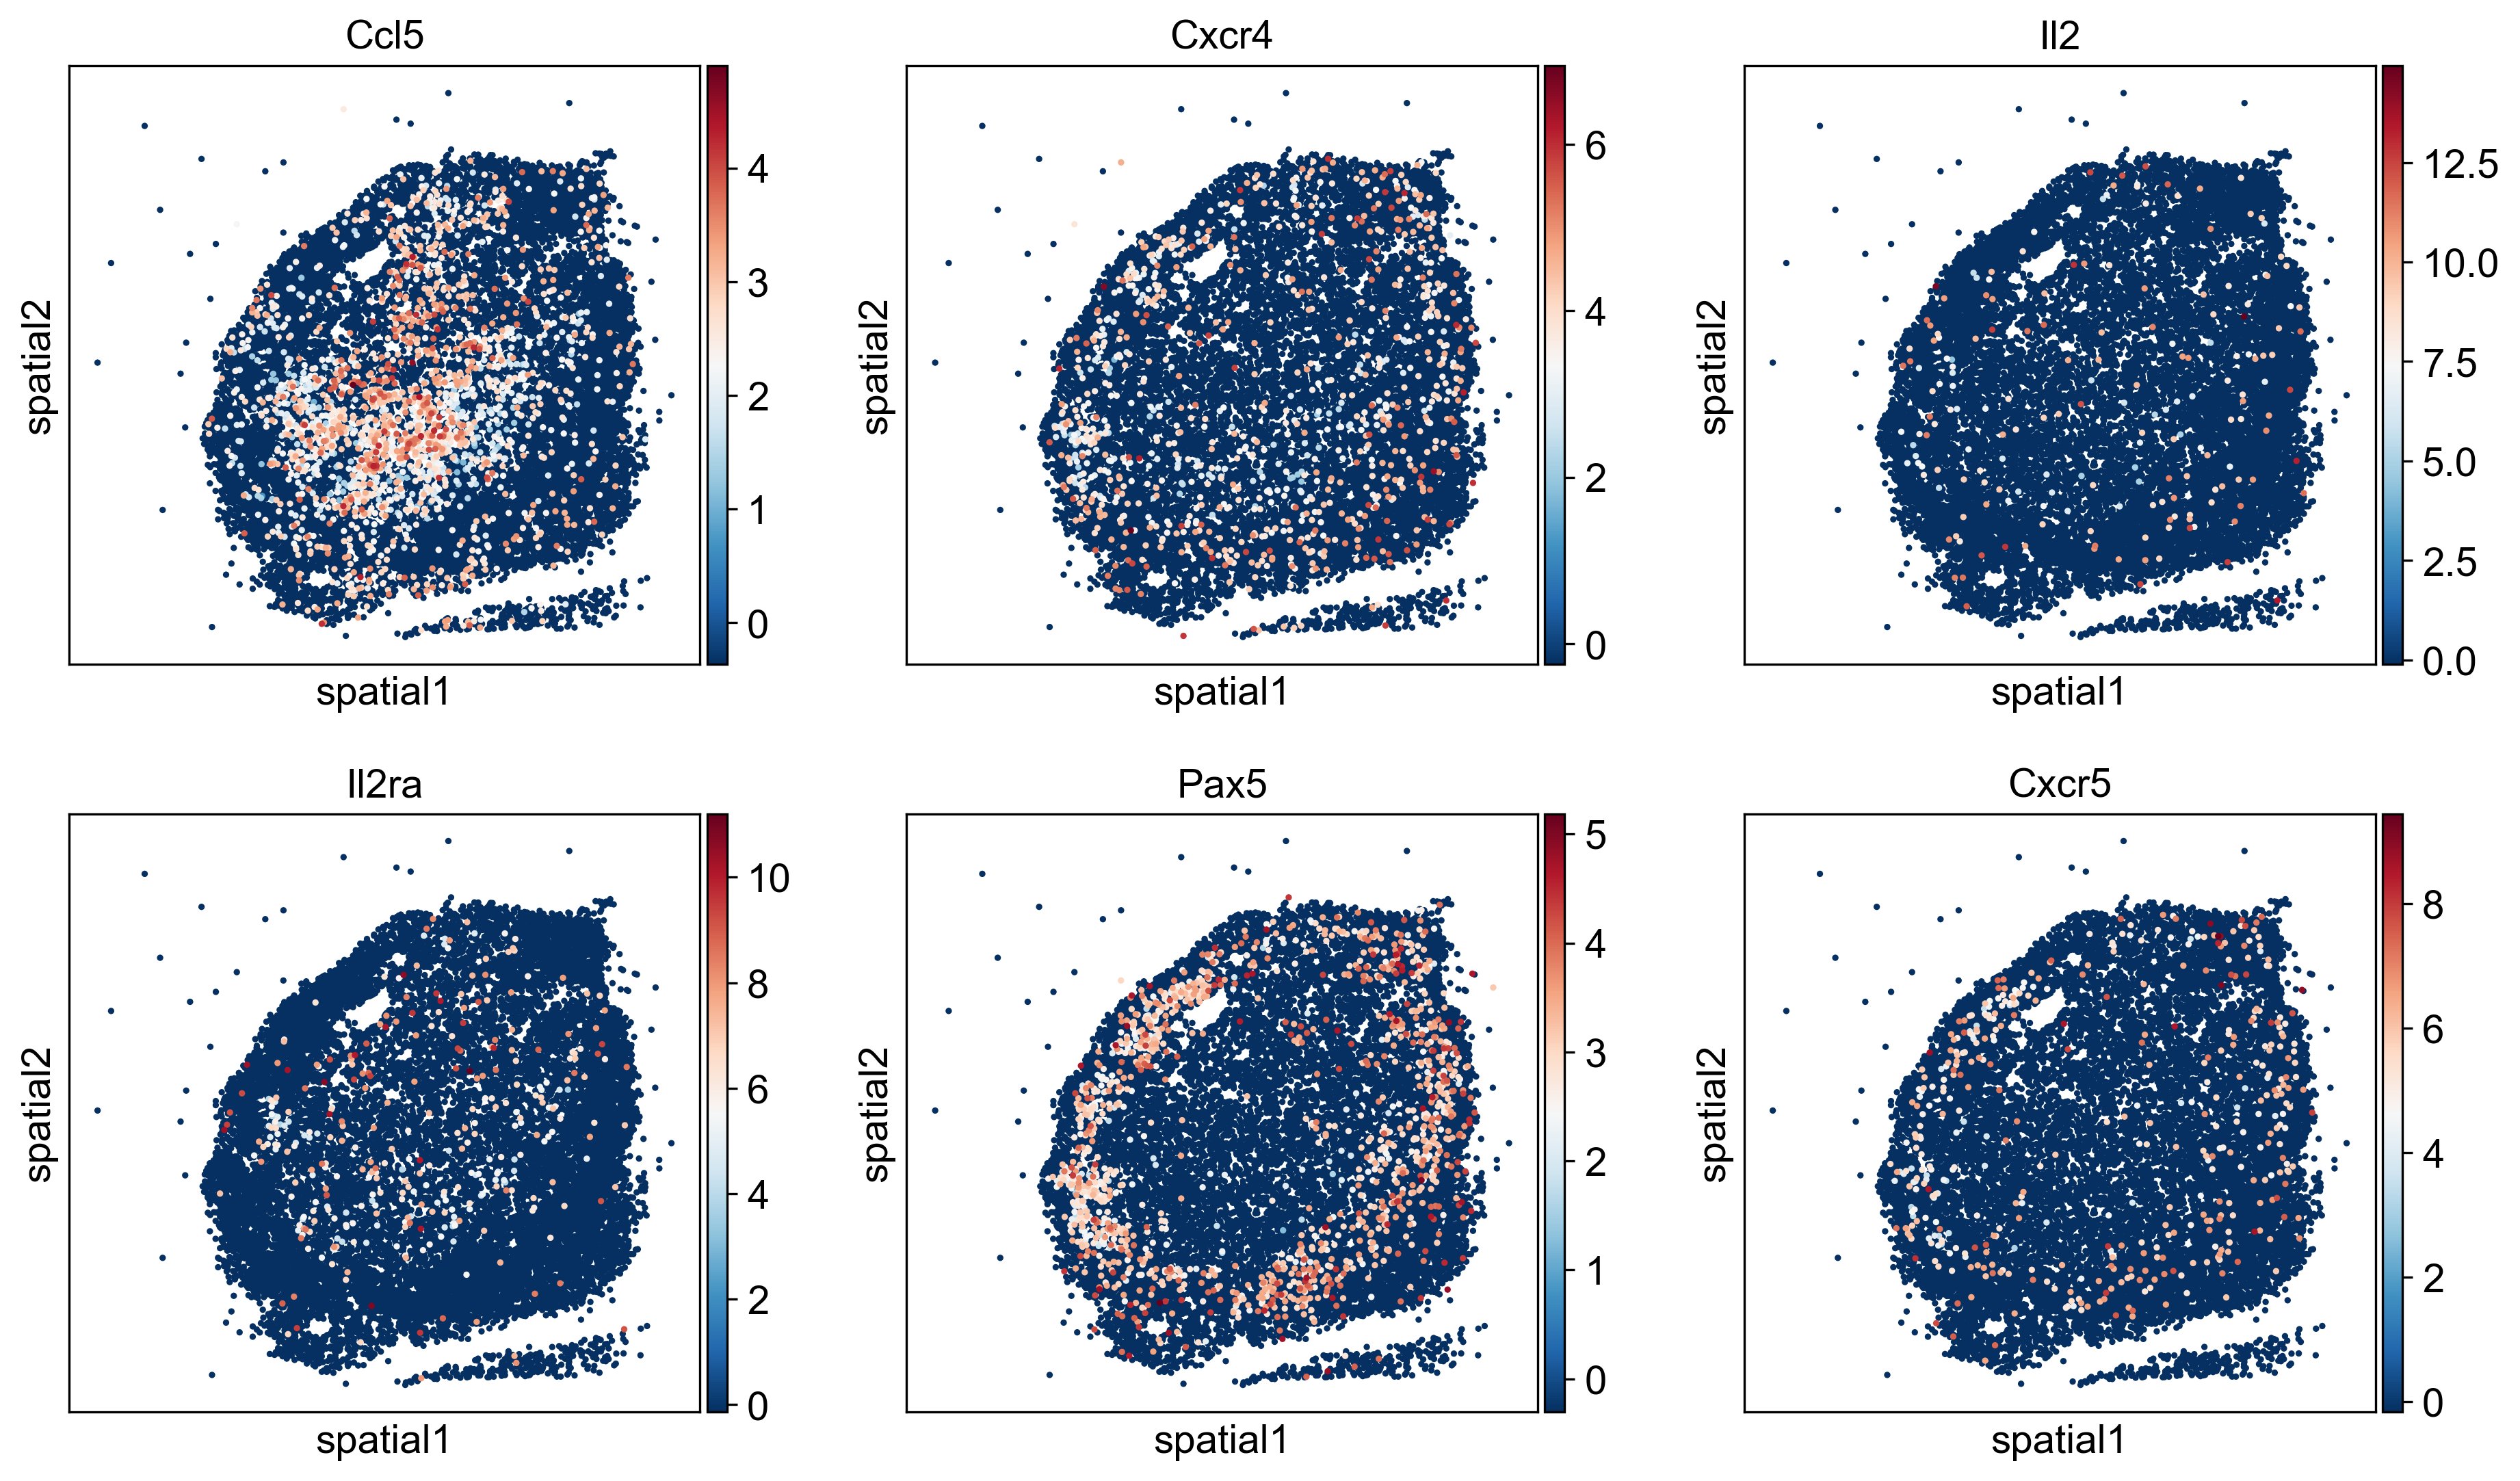

In [46]:
sc.pl.embedding(
    adata, color = ['Ccl5', 'Cxcr4', 'Il2', 'Il2ra', 'Pax5', 'Cxcr5'],
    cmap = 'RdBu_r', layer='normalized',
    basis='spatial', ncols=3,
    s=20,
)

In [47]:
# obtain some embeddings.
adata.obsm['normalized_pca'] = sc.pp.pca(adata.layers['normalized'])
adata.obsm['imputated_pca'] = sc.pp.pca(adata[:, adata.var.query('spanve_spatial_features').index].layers['imputated'])
sc.pp.neighbors(adata, use_rep='normalized_pca', metric='cosine')
sc.tl.leiden(adata, resolution=0.5, key_added='leiden_05')

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


Sample size: 15920, using model: MiniBatchKMeans


finding best cluster number: 100%|██████████| 13/13 [00:02<00:00,  5.31it/s]


Best k: 8, Now predicting


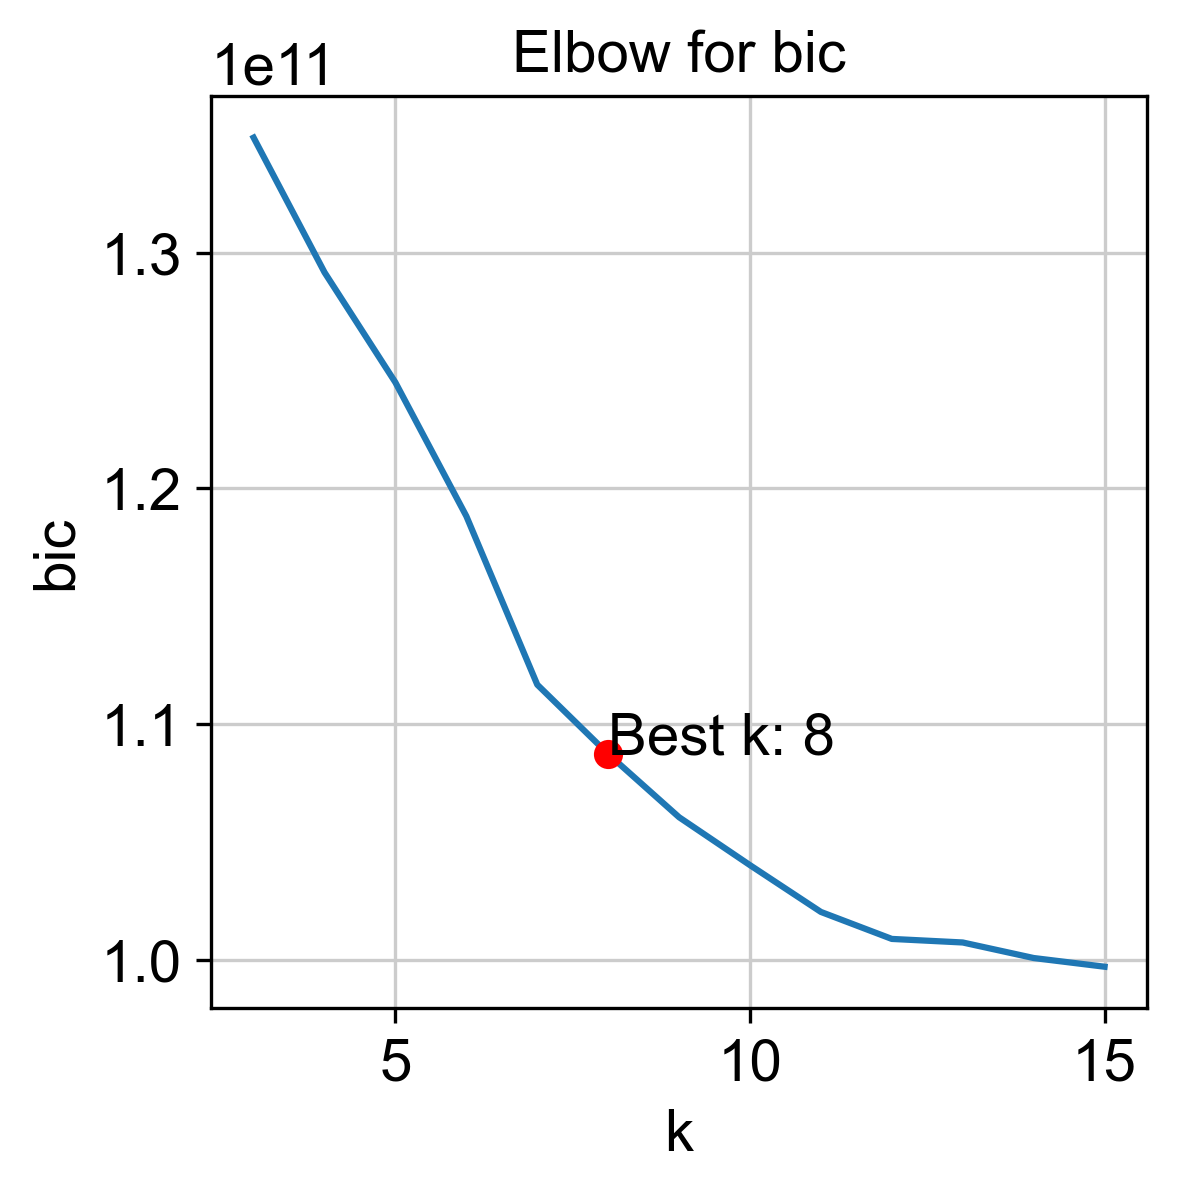

In [48]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from Spanve import AutoCluster

cluster = AutoCluster(init_k=3,max_k=15,criteria = 'bic')
labelx = cluster.fit_predict(adata.obsm['imputated_pca'],verbose=True)
cluster.plot_elbow()
adata.obs['imputated_KM'] = labelx.astype(str)
adata.obs['normalized_KM'] = KMeans(n_clusters = cluster.best_k).fit_predict(adata.obsm['normalized_pca']).astype(str)

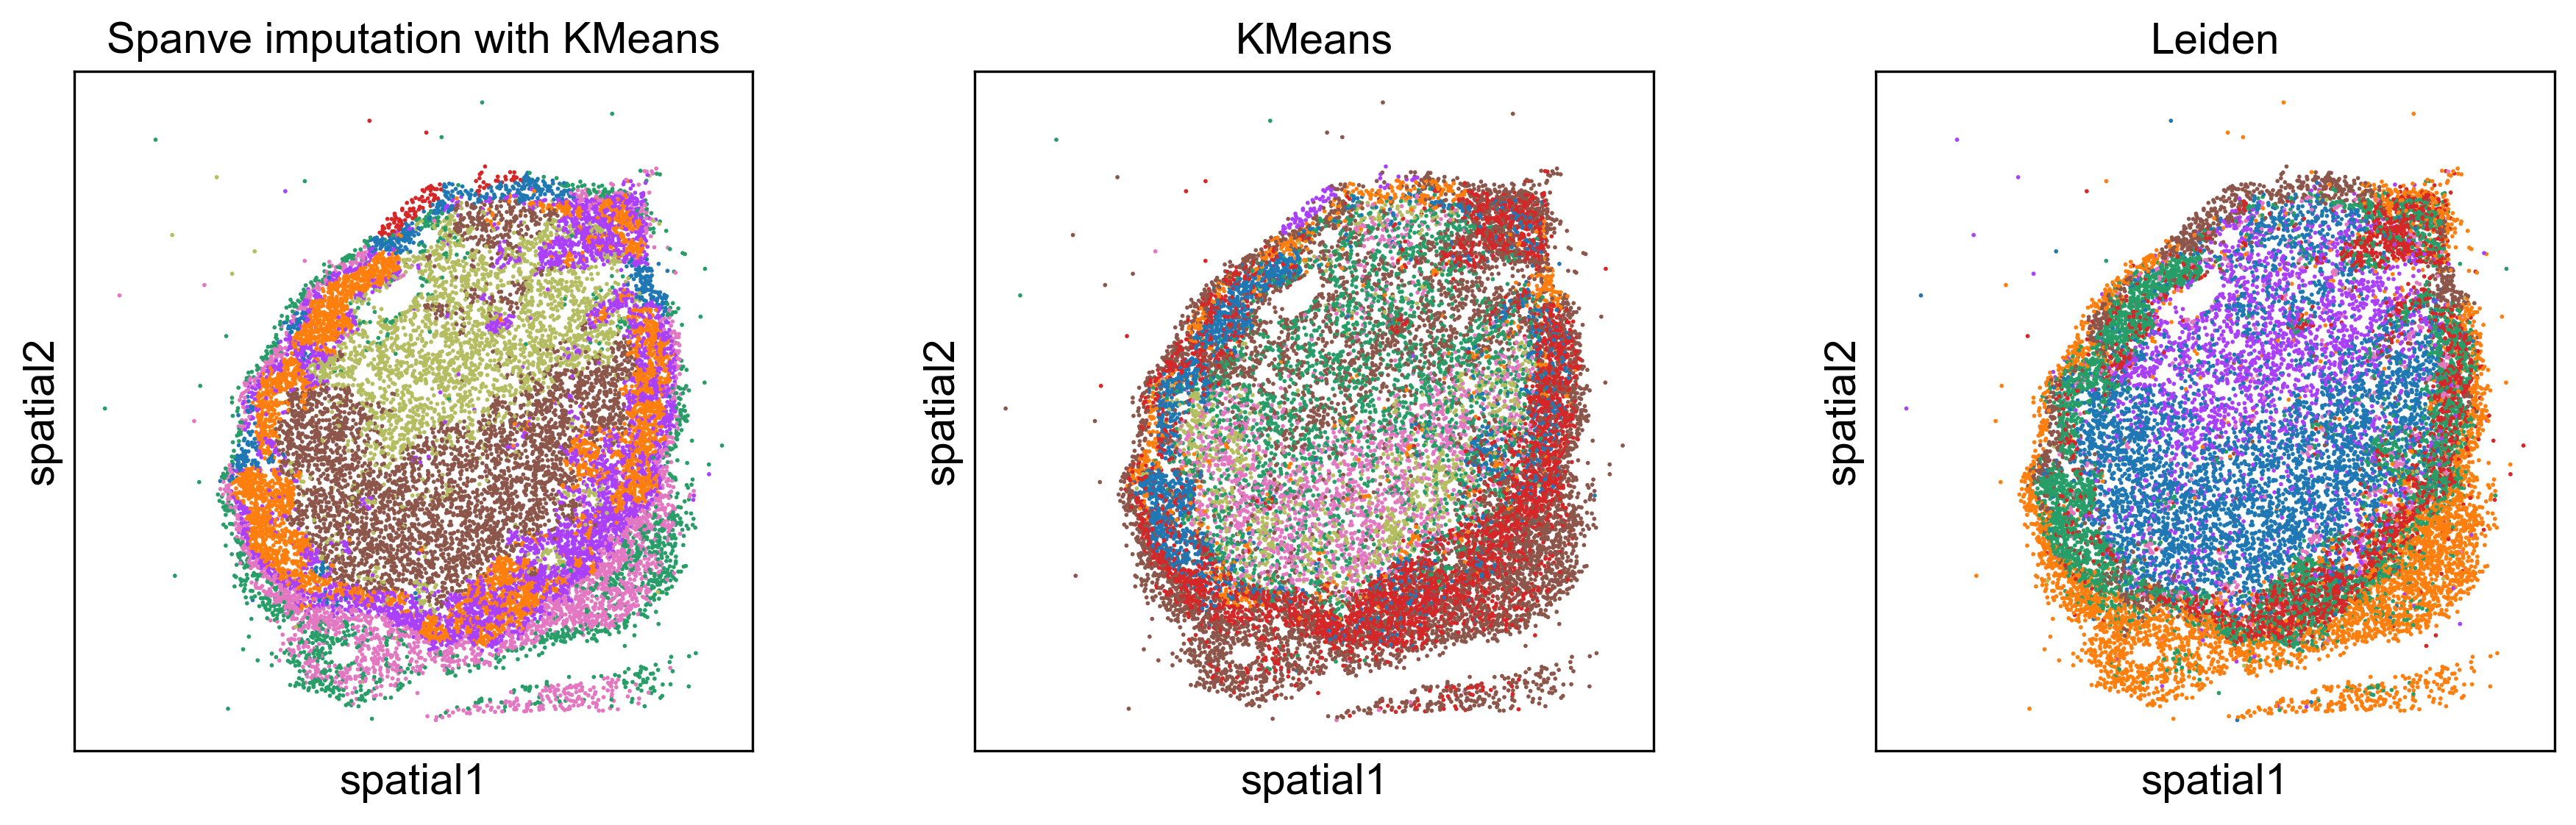

In [50]:
sc.pl.embedding(
    adata, color= ['imputated_KM', 'normalized_KM', 'leiden_05'],
    legend_loc=None, basis='spatial',
    title= ['Spanve imputation with KMeans', 'KMeans', 'Leiden'],
    ncols = 3,
)